In [3]:
import matplotlib.pyplot as plt
import librosa
from modules.zncc import compute_zncc_map
from modules.plot_spectrogram import plot_spectrogram
from modules.dataset import SpeechDataset
from modules.down_sample import downsample_to_8k
from modules.low_pass import apply_lowpass_filter
from modules.subsample import subsample

In [2]:
# noise_type = "0_air_conditioner"
noise_type = "white"
dataset = SpeechDataset(noise_type=noise_type)

itter = iter(dataset)

noisy, clean = next(itter)

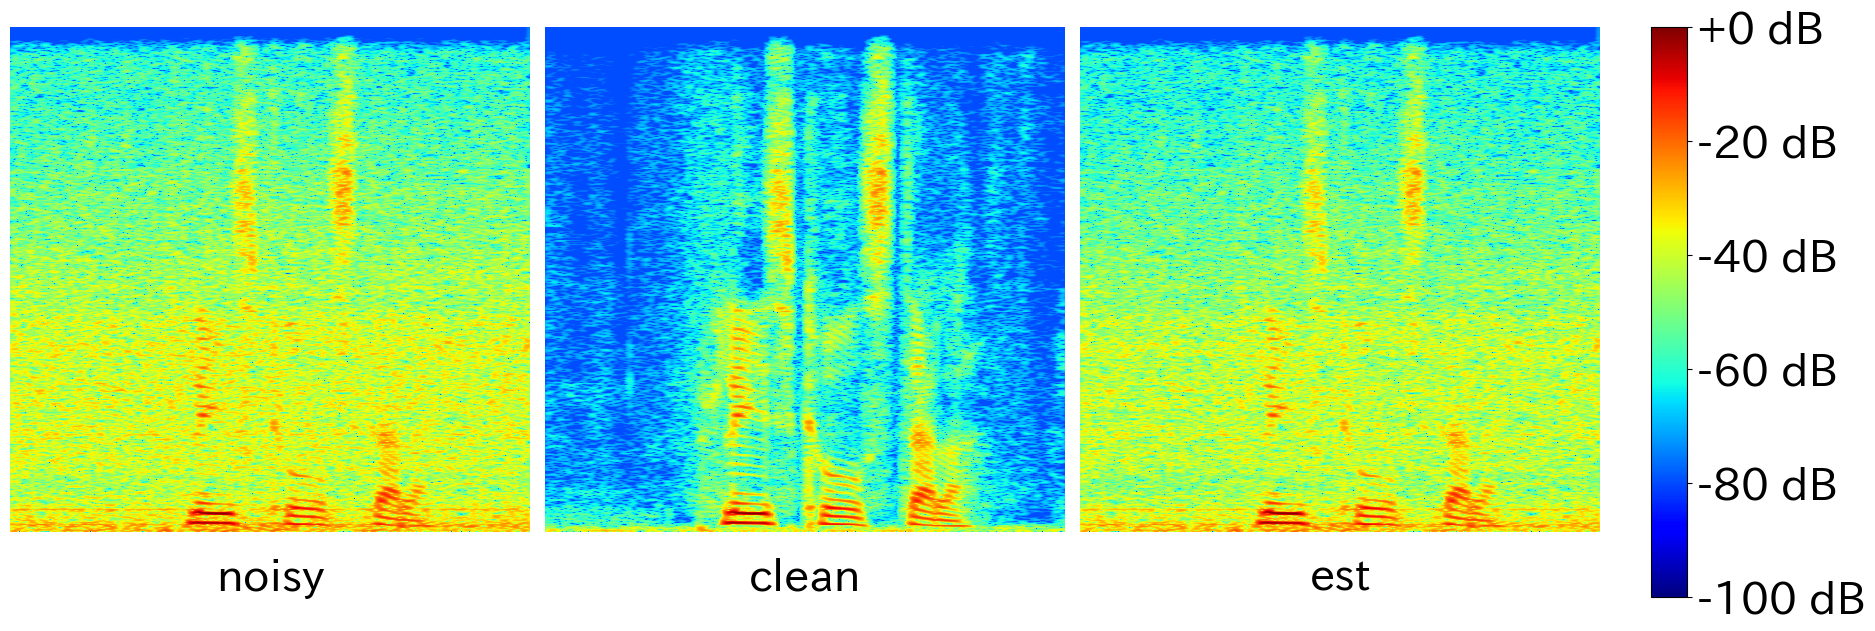

In [45]:
noisy_path = "/Users/rockwell/Documents/python/SE-with-SubSampler/src/for_academic/air_con/noisy.wav"
# noisy_path = "/Users/rockwell/Documents/python/SE-with-SubSampler/src/for_academic/spline/TF/white/noisy.wav"
clean_path = "/Users/rockwell/Documents/python/SE-with-SubSampler/src/for_academic/spline/TF/air_con/clean.wav"
est_path = "/Users/rockwell/Downloads/TF_simple_downsampling_air_conditioner.wav"

fig,axs = plt.subplots(1, 3, figsize=(18, 6))
axs = axs.flatten()

# ノイジー音声のスペクトログラム
noisy, sr = librosa.load(noisy_path, sr=None)
plot_spectrogram(axs[0], noisy, sr, "noisy")

# クリーン音声のスペクトログラム
clean, sr = librosa.load(clean_path, sr=None)
plot_spectrogram(axs[1], clean, sr, "clean")

# 推定音声のスペクトログラム
est, sr = librosa.load(est_path, sr=None)
img = plot_spectrogram(axs[2], est, sr, "est")

# カラーバーの表示 fontsize=32
plt.tight_layout(rect=[0, 0, 0.9, 1])

# 色バーの高さをグリッドの2行分に合わせる
# カラーバーの高さ (相対値) = 2 / nrows, 縦方向中央に配置するための bottom = (1 - height) / 2
cbar_height = 1 - 0.05  # 2行分の高さを取得
cbar_bottom = (1 - cbar_height) / 2  # 縦方向中央に配置するための bottom

# 右側にカラーバー用の軸を追加
cbar_ax = fig.add_axes([0.92, cbar_bottom, 0.02, cbar_height])

cbar = fig.colorbar(img, cax=cbar_ax, format="%+2.0f dB")
cbar.ax.tick_params(labelsize=32)

plt.savefig("./output.pdf", format="pdf", bbox_inches="tight")
plt.show()
plt.close()

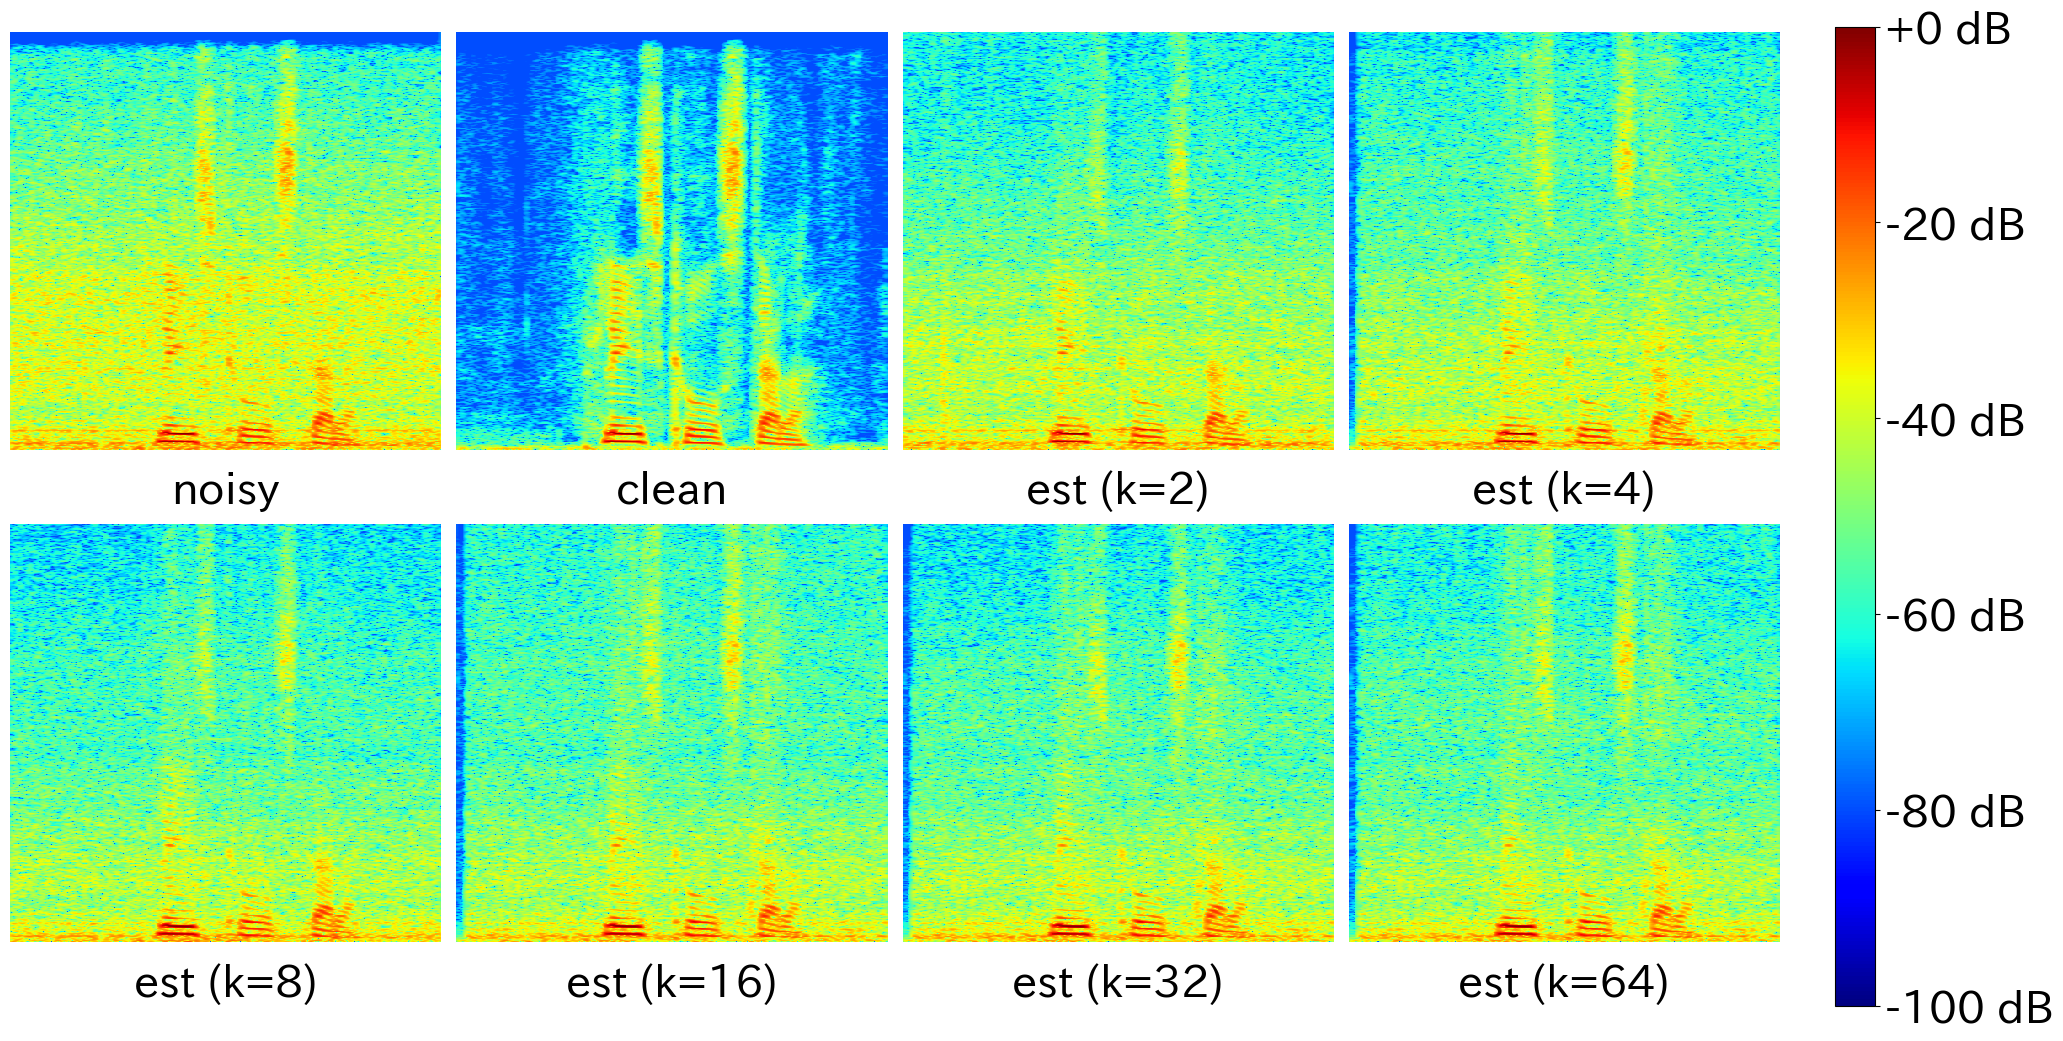

PDF saved to: ./output_white_waveforms.pdf


In [32]:
import matplotlib.pyplot as plt
import japanize_matplotlib  # 日本語フォント対応（必要に応じて）
import numpy as np
import os
import librosa
import librosa.display

import glob


def plot_spectrogram(ax, wav, sample_rate, title, font_size=10):
    """
    スペクトログラムをプロットし、タイトルを下部中央に配置します。
    """
    hop_length = 64
    n_fft = 1024
    min_db = -100
    max_db = 0

    # STFTの計算
    D = librosa.stft(wav, n_fft=n_fft, hop_length=hop_length)
    D_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

    # スペクトログラムの表示
    img = librosa.display.specshow(
        D_db,
        sr=sample_rate,
        hop_length=hop_length,
        cmap="jet",
        vmin=min_db,
        vmax=max_db,
        ax=ax,
    )

    # タイトルを下部中央に配置（日本語OK）
    ax.axis("off")  # 軸を非表示
    ax.text(
        0.5,
        -0.05,
        title,
        fontsize=font_size,
        ha="center",
        va="top",
        transform=ax.transAxes,
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="none", pad=3),
    )
    return img


# 設定
noise_name = "air_con"
# noise_name = "white"
subsample_ks = [2, 4, 8, 16, 32, 64]
base_url = "/Users/rockwell/Documents/python/SE-with-SubSampler/src/for_academic/spline/time"
output_pdf_path = "./output_white_waveforms.pdf"
font_size = 32

# データ読み込みリスト（各タプル: (タイトル, wav, sr)）
data = []

# "noisy" 信号の読み込み
noisy_path = os.path.join(base_url, noise_name, "noisy.wav")
if not os.path.exists(noisy_path):
    print(f"ファイルが存在しません: {noisy_path}")
else:
    wav, sr = librosa.load(noisy_path, sr=None)
    data.append(("noisy", wav, sr))

# "clean" 信号の読み込み
clean_path = os.path.join(base_url, noise_name, "clean.wav")
if not os.path.exists(clean_path):
    print(f"ファイルが存在しません: {clean_path}")
else:
    wav, sr = librosa.load(clean_path, sr=None)
    data.append(("clean", wav, sr))

# 各 subsample_k に対する推定信号の読み込み
for k in subsample_ks:
    # globを使ってpred_cleanで始まるwavファイルを検索
    est_pattern = os.path.join(base_url, noise_name, f"k={k}", "pred_clean*.wav")
    est_files = glob.glob(est_pattern)  # パターンにマッチするファイルのリストを取得

    if not est_files:  # ファイルが一つも存在しない場合
        print(f"ファイルが存在しません: {est_pattern}")  # エラーメッセージにパターンを表示するように修正
        continue

    for est_path in est_files:  # 複数ファイルがマッチした場合も考慮してループ (通常は1つのはず)
        wav, sr = librosa.load(est_path, sr=None)
        data.append((f"est (k={k})", wav, sr))

# プロット設定
num_signals = len(data)
ncols = 4
nrows = (num_signals + ncols - 1) // ncols  # 必要な行数を計算

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))
axes = axes.flatten()

# どれか1つのスペクトログラムの画像オブジェクトを取得するための変数
im = None

for i, (title, wav, sr) in enumerate(data):
    im = plot_spectrogram(axes[i], wav, sr, title, font_size=font_size)

# 余ったサブプロットを非表示に
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

# レイアウト調整：右端にカラーバーを配置できるようにレイアウト幅を調整
plt.tight_layout(rect=[0, 0, 0.9, 1])

# 色バーの高さをグリッドの2行分に合わせる
# カラーバーの高さ (相対値) = 2 / nrows, 縦方向中央に配置するための bottom = (1 - height) / 2
cbar_height = 2 / nrows - 0.02  # 2行分の高さを取得
cbar_bottom = (1 - cbar_height) / 2   # 縦方向中央に配置するための bottom    

# 右側にカラーバー用の軸を追加
cbar_ax = fig.add_axes([0.92, cbar_bottom, 0.02, cbar_height])
cbar = fig.colorbar(im, cax=cbar_ax, format="%+2.0f dB")
cbar.ax.tick_params(labelsize=32)

plt.savefig(output_pdf_path, format="pdf", bbox_inches="tight")
plt.show()
plt.close()

print(f"PDF saved to: {output_pdf_path}")